#### Hierarchical Multi Agent System

This system has Top supervisor which will route flow to two teams (Research / Document Authoring). Then both teams wil have agents with multiple tools bind to themselves.

In [14]:
# Import the necessary libraries
from typing import Annotated, List,Dict, Optional
from typing_extensions import TypedDict, Literal
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pathlib import Path
from langchain_groq import ChatGroq
from tempfile import TemporaryDirectory
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import create_react_agent
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

In [23]:
# Define LLM model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3)

##### Research Team

In [24]:
# Define the tools
tavily_tool = TavilySearchResults(max_results=5) 

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(web_path=urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title","")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

##### Document Writing Team

In [25]:
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

In [26]:
# Define the tools
@tool
def create_outline(points: Annotated[List[str],"List of main points or sections"],
                   file_name: Annotated[str, "File path to save the outline."],
                   ) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with open(WORKING_DIRECTORY / file_name,'w') as file:
        for i, point in enumerate(points):
            file.write(f"{i+1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with open(WORKING_DIRECTORY/file_name,'r') as file:
        lines = file.readlines
    if start is None:
        start = 0
    return '\n'.join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with open(WORKING_DIRECTORY/file_name,'w') as file:
        file.write(content)
    return f"Document saved to the {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""
    with open(WORKING_DIRECTORY/file_name,'w') as file:
        lines = file.readlines

    sorted_inserts = sorted(inserts.items())
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines)+1:
            lines.insert(line_number-1,text+"\n")
        else:
            return f"Error: Line number {line_number} is out of range."


    with open(WORKING_DIRECTORY/file_name,"w") as file:
        file.writelines(lines)
    return f"Document edited and saved to {file_name}"

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except Exception as e:
        return f"Failed to execute. Error : {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

In [27]:
# Define the state:
class State(MessagesState):
    next: str

In [28]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node 



In [29]:
# search agent
search_agent = create_react_agent(llm, tools=[tavily_tool])
def search_node(state:State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(goto='supervisor',update={"messages":[HumanMessage(content=result["messages"][-1].content,name="search")]})

# web scraper agent
web_scraper_agent = create_react_agent(llm,tools=[scrape_webpages])
def web_scraper_node(state:State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(goto="supervisor",update={"messages":[HumanMessage(content=result["messages"][-1].content,name="web_scraper")]})

research_supervisor_node = make_supervisor_node(llm,["search","web_scraper"])

In [30]:
research_builder = StateGraph(State)

research_builder.add_node("supervisor",research_supervisor_node)
research_builder.add_node("search",search_node)
research_builder.add_node("web_scraper",web_scraper_node)

research_builder.add_edge(START,"supervisor")
research_graph = research_builder.compile()

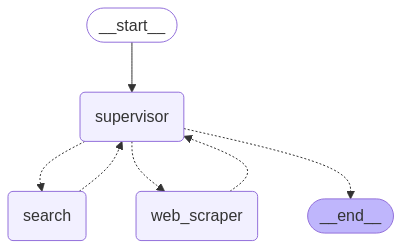

In [31]:
research_graph

In [32]:
for s in research_graph.stream(
    {"messages": [("user", "The next ODI world cup venue and when it will happen ?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='The next ODI World Cup is scheduled to take place in India from October 5 to November 19, 2023.', additional_kwargs={}, response_metadata={}, name='search', id='bf0a6e8f-d91c-4e7e-95ad-ed6107343741')]}}
---
{'supervisor': {'next': '__end__'}}
---
